# iWildCam2019

>[iWildCam2019](#scrollTo=nQujD-ki_yfE)

>>[Setup](#scrollTo=v7ubple5ALS7)

>>[Installs](#scrollTo=6d83TEioz3Hb)

>>>[Imports](#scrollTo=8lFIH8fGATeI)

>>>[Google Drive](#scrollTo=h1ujOfPrAWUo)

>>>>[Unzip data](#scrollTo=L7I8ACtyGjkm)

>>>>[Unzip test images](#scrollTo=IS3A4kcEGuFM)

>>>[CUDA](#scrollTo=cWUpEtLBAau2)

>>[Code](#scrollTo=iXMe-rPVXMcl)

>>>>[Constants](#scrollTo=32NsTMTGZ291)

>>>[Utils](#scrollTo=zazk-8clXRNH)

>>>[Model](#scrollTo=qiYM4vItXWgx)

>>>[Training Functions](#scrollTo=2LNbi9XkXtvj)

>>>>[Helper Functions](#scrollTo=ozIOIHDQahrB)

>>>>[do_train()](#scrollTo=1BndLmnkFJOw)

>>>[Evaluation Functions](#scrollTo=bUhpo37_XxC6)

>>>>[Helper Functions](#scrollTo=WUZmX9oAK7H4)

>>>>[do_predict()](#scrollTo=6YpegjB0K3_-)

>>[Training](#scrollTo=_Axh_B1zXaZM)

>>[Prediction](#scrollTo=6uFYQPC1Xdf2)

>>[Submit](#scrollTo=jx6n4g6L7bRU)



## Setup

## Installs

In [ ]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#! pip install efficientnet

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


### Imports

In [ ]:

import os

from collections import OrderedDict
import math
from time import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
tf.debugging.set_log_device_placement(False)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.python.data import AUTOTUNE
# from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.densenet import DenseNet121

import cv2
from google.colab import drive


In [ ]:
tf.version.VERSION

'2.11.0'

### Google Drive

In [ ]:
PROJECT_PATH= '/content/drive/MyDrive/statistical_inference/iWildCam_2019'

In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [ ]:
drive.mount('/content/drive')
# file_path = os.path.join(PROJECT_PATH,'data/weatherAUS.csv' )
# data=pd.read_csv(file_path)')

list_files(PROJECT_PATH)

Mounted at /content/drive
iWildCam_2019/
    DenseNet-BC-121-32-no-top.h5
    history-EfficientNetB0.json
    result-EfficientNetB0.csv
    pred-EfficientNetB0.csv
    history-EfficientNetV2B0.json
    result-EfficientNetV2B0.csv
    pred-EfficientNetV2B0.csv
    history-DenseNet121.json
    Downloads/
        Data.zip
        train_128_128_images.zip
        test_128_128_images.zip
    Models/
        EfficientNetB0.index
        EfficientNetB0.data-00000-of-00001
        EfficientNetV2B0.data-00000-of-00001
        EfficientNetV2B0.index
        DenseNet121.index
        checkpoint
        DenseNet121.data-00000-of-00001
    checkpoints/
        EfficientNetB0/
            cp-0023.ckpt.data-00000-of-00001
            cp-0023.ckpt.index
            cp-0026.ckpt.data-00000-of-00001
            cp-0026.ckpt.index
            cp-0029.ckpt.data-00000-of-00001
            cp-0029.ckpt.index
            cp-0032.ckpt.data-00000-of-00001
            cp-0032.ckpt.index
            cp-0036.ckpt

#### Unzip data

In [ ]:
data_zip_path=os.path.join(PROJECT_PATH,'Downloads','Data.zip' )
!unzip -n {data_zip_path}

Archive:  /content/drive/MyDrive/statistical_inference/iWildCam_2019/Downloads/Data.zip
  inflating: train+.csv              
  inflating: caltech_images_20210113.json  
  inflating: inat.csv                
  inflating: test.csv                
  inflating: test.ftr                
  inflating: train.csv               
  inflating: train.ftr               


Unzip training images

In [ ]:
train_images_path=os.path.join(PROJECT_PATH,'Downloads','train_128_128_images.zip' )
!unzip -q -n {train_images_path}

#### Unzip test images

In [ ]:
test_images_path=os.path.join(PROJECT_PATH,'Downloads','test_128_128_images.zip' )
!unzip -q -n {test_images_path}

### CUDA

In [ ]:
gpus=tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if len(gpus):
  print(gpus)


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
tf.ones([])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
with tf.device("CPU"):
 print(tf.ones([]))

tf.Tensor(1.0, shape=(), dtype=float32)


## Code

#### Constants

In [ ]:
BATCH_SIZE = 64
# EPOCHS = 20
EPOCHS = 20
# STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 50
MODEL='DenseNet121'
TARGET_SIZE=(32,32)
# TARGET_SIZE=(128,128)
# TRAIN_METRIC='sparse_categorical_accuracy'
TRAIN_LOSS='sparse_categorical_crossentropy'
TRAIN_METRIC='accuracy'
# TRAIN_LOSS='categorical_crossentropy'
LEARNING_RATE=0.00005

In [ ]:
EPOCHS

20

### Utils

In [ ]:
def get_data_file_path(*components):
    return os.path.join('/content', *components)

def load_df(name) -> pd.DataFrame:
    path = get_data_file_path(name + '.csv')
    return pd.read_csv(path, dtype={'id': str, 'seq_id': str})
  
def get_drive_file_path(*components):
    return os.path.join(PROJECT_PATH, *components)

def save_df(df,name):
  path=get_drive_file_path(name+'.csv')
  df.to_csv(path, index=False)
  print(f'Saved to {path}')

def save_array(arr,name):
  path=get_drive_file_path(name+'.csv')
  np.savetxt(path,arr,delimiter=',')

def load_df_from_drive(name):  
  path=get_drive_file_path(name+'.csv')
  return pd.read_csv(path)

def load_array(name):
      path=get_drive_file_path(name+'.csv')
      return np.loadtxt(path, delimiter=',')

def make_dir(path):
  if not  os.path.exists(path):
     os.makedirs(path)

def save_history(history,model_name):
  path=get_drive_file_path(f'history-{model_name}')
  save_json(history.history, path)
  return history.history

def load_history(model_name):
  path=get_drive_file_path(f'history-{model_name}')
  return load_json(path)

def load_json(path):
  with open(path+'.json', 'r') as openfile: 
    return json.load(openfile)

def save_json(dictionary, path):
  with open(path+'.json', "w") as outfile:
      json.dump(dictionary, outfile)

In [ ]:
# df=pd.DataFrame({'id':[1,2,3],'val':['a','b','c']})
# save_df(df,'dummy')
# df1=load_df_from_drive('dummy')
# df1

In [ ]:
# arr=np.array([[1,2],[3,4],[5,6]])
# save_array(arr,'dummy1')
# arr1=load_array('dummy1')
# arr1

In [ ]:
# load_df('test').info()

### Model

In [ ]:
def save_model(model, model_name):
    save_path = get_model_path(model_name)
    model.save_weights(save_path)


def load_model(model_name, num_classes):
    load_path = get_model_path(model_name)
    model=create_model(model_name, num_classes)
    model.load_weights(load_path)
    return model


def get_model_path(model_name):
    return get_drive_file_path('Models', model_name)

MODEL_CLASSES={
    'EfficientNetB0':EfficientNetB0,
    'EfficientNetB7':EfficientNetB7,
    'EfficientNetV2B0':EfficientNetV2B0,
    'DenseNet121': {'model_class':DenseNet121, 'weights':'DenseNet-BC-121-32-no-top.h5'}

}
def create_model(model_name, num_classes):
    model_class_ = MODEL_CLASSES[model_name]
    if type(model_class_)==dict:
      model_class=model_class_['model_class']
      weights=get_drive_file_path(model_class_['weights'])
    else:
        model_class=model_class_
        weights="imagenet"
    print('weights', weights)
    pre_trained_model = model_class(weights=weights, include_top=False, input_shape=(*TARGET_SIZE, 3))
    for layer in pre_trained_model.layers:
        layer.trainable = False
    # pre_trained_model.summary()
    # tuning on pre-trained model
    effnet_model = tf.keras.models.Sequential()
    effnet_model.add(pre_trained_model)
    effnet_model.add(tf.keras.layers.GlobalAveragePooling2D())
    effnet_model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
    # effnet_model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    effnet_model.compile(optimizer=opt,
                         loss=TRAIN_LOSS,
                         metrics=[TRAIN_METRIC])
    return effnet_model

In [ ]:
# create_model('EfficientNetB0',23)

### Training Functions

#### Helper Functions

In [ ]:
def flow_from_dataframe(datagen, x_train, dir_name, subset=None):
    directory = get_data_file_path(dir_name)
    params = {
        'dataframe': x_train,
        'directory': directory,
        'x_col': "file_name",
        'batch_size': BATCH_SIZE,
        'seed': 424,
        'shuffle': True,
        'target_size': TARGET_SIZE,
        'validate_filenames': True
    }
    if subset:
        params['subset'] = subset
        params['y_col'] = "category_id"
        params['class_mode'] = "raw"
    else:
        params['y_col'] = None
        params['class_mode'] = None

    generator = datagen.flow_from_dataframe(**params)
    # print(subset, set(generator.labels))
    return generator

In [ ]:
# test_df = load_df('test')
# datagen = ImageDataGenerator(rescale=1. / 255)
# flow_from_dataframe(datagen, test_df, 'test_128_128_images')

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    # ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

#### do_train()

In [ ]:
CHECKPOINT_DIR=get_drive_file_path(f'checkpoints/{MODEL}')

def do_train(model_name):
    print(model_name)
    x_train = load_df('train+')
    num_classes = x_train['category_id'].nunique()
    print('num_classes',num_classes)
    validation_split=0.25 
    train_datagen = ImageDataGenerator(validation_split=validation_split)
    # train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=validation_split)
    train_generator = flow_from_dataframe(train_datagen, x_train, 'train_128_128_images', subset="training")
    valid_generator = flow_from_dataframe(train_datagen, x_train, 'train_128_128_images', subset="validation")

    model = create_model(model_name, num_classes)
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
                                             start_from_epoch=5)
    checkpoint_path=os.path.join(CHECKPOINT_DIR,'cp-{epoch:04d}.ckpt')
    total_steps = x_train.shape[0] // BATCH_SIZE
    validation_steps=int(total_steps*validation_split)
    steps_per_epoch=total_steps-validation_steps
    cp_callback=ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=steps_per_epoch,
                                                 verbose=1)
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_steps=validation_steps,
        callbacks=[early,cp_callback]
    )
    save_model(model, model_name)
    return save_history(history,model_name)

### Evaluation Functions

#### Helper Functions

In [ ]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    # rescaled_image = tf.cast(img, dtype=tf.float32) / tf.constant(255, dtype=tf.float32)
    # return rescaled_image
    img=tf.image.resize(img,TARGET_SIZE, 'bicubic')
    return img


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

def get_image_data_set(dir_name):
    directory = get_data_file_path(dir_name)
    list_ds = tf.data.Dataset.list_files(directory + '/*', shuffle=False)
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds, tfds.as_dataframe(list_ds)

In [ ]:
class PredictProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.count = 0

    def on_predict_batch_begin(self, batch, logs=None):
        self.count += 1
        print(f'batch {self.count} start')
        pass

    def on_predict_batch_end(self, batch, logs=None):
        print(f'batch {self.count} end')

    def on_predict_begin(self, logs=None):
        print(f'predict begin: {self.params}')

    def on_predict_end(self, logs=None):
        print('predict end')

#### do_predict()

In [ ]:
def get_id(path_arr):
    filename = os.path.basename(str(path_arr))
    return os.path.splitext(filename)[0]

def do_predict(model_name, is_test=False, num_classes=23):
    print(model_name)
    x_test=load_df('test')
    model = load_model(model_name, num_classes=num_classes)
    suffix='_10' if is_test else ''
    test_datagen = ImageDataGenerator()
    dir_name=f'test_128_128_images{suffix}'
    # print('dir_name',dir_name)
    test_generator = flow_from_dataframe(test_datagen, x_test, dir_name)

    pred = model.predict(test_generator)
    result = x_test[['file_name']]
    result.rename(columns={'file_name': 'Id'}, inplace=True)
    result['Id'] = result['Id'].apply(get_id)
    categories_arr = pred.argmax(axis=1)
    result['Predicted'] = categories_arr
    save_df(result,f'result-{model_name}')
    save_array(pred,f'pred-{model_name}')
    return result, pred

## Training

In [ ]:
history_dict=do_train(MODEL)

DenseNet121
num_classes 23
Found 166170 validated image filenames.
Found 55390 validated image filenames.
weights /content/drive/MyDrive/statistical_inference/iWildCam_2019/DenseNet-BC-121-32-no-top.h5
Epoch 1/20
2594/2596 [============================>.] - ETA: 0s - loss: 1.8141 - accuracy: 0.5827
Epoch 1: saving model to /content/drive/MyDrive/statistical_inference/iWildCam_2019/checkpoints/DenseNet121/cp-0001.ckpt
2596/2596 [==============================] - ETA: 0s - loss: 1.8137 - accuracy: 0.5827

KeyboardInterrupt: ignored

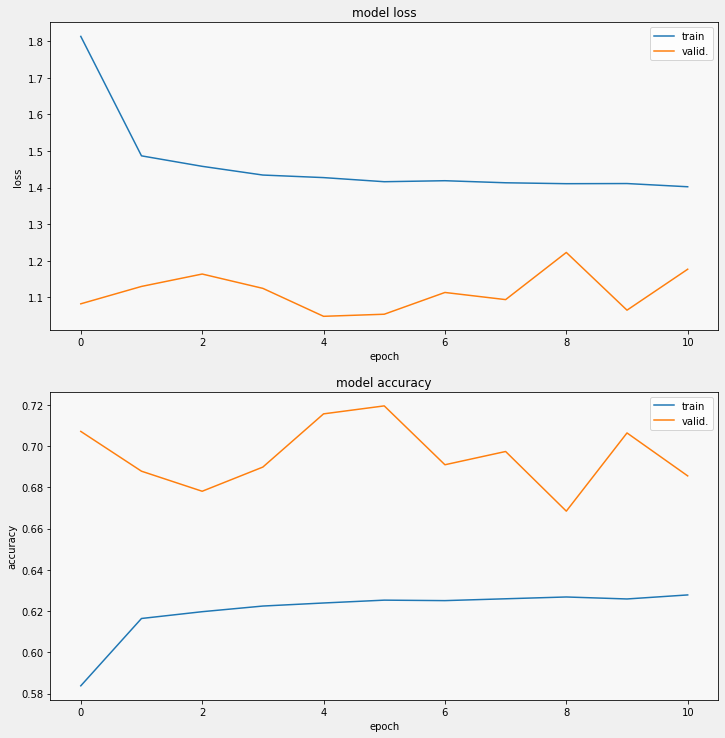

In [ ]:
   history_dict=load_history(MODEL)
   display_training_curves(history_dict['loss'], history_dict['val_loss'], 'loss', 211)
   display_training_curves(history_dict[TRAIN_METRIC], history_dict[f'val_{TRAIN_METRIC}'], 'accuracy', 212)

## Prediction

In [ ]:
src_dir=get_data_file_path('test_128_128_images')
dst_dir=get_data_file_path('test_128_128_images_10')
make_dir(dst_dir)

files = os.listdir(src_dir)
files_10=files[:10]

import shutil
for filename in files_10:
  src_path=os.path.join(src_dir,filename)
  dst_path=os.path.join(dst_dir,filename)
  shutil.copy(src_path,dst_path)

In [ ]:
result, pred=do_predict(MODEL, is_test=False)
# result, pred=do_predict(MODEL, is_test=True)

NameError: ignored

In [ ]:
result

,Id,Predicted
0,bce932f6-2bf6-11e9-bcad-06f10d5896c4,1
1,bce932f7-2bf6-11e9-bcad-06f10d5896c4,1
2,bce932f8-2bf6-11e9-bcad-06f10d5896c4,1
3,bce932f9-2bf6-11e9-bcad-06f10d5896c4,0
4,bce932fa-2bf6-11e9-bcad-06f10d5896c4,1
...,...,...
153725,88613521-2c22-11e9-bcad-06f10d5896c4,1
153726,88613522-2c22-11e9-bcad-06f10d5896c4,16
153727,88613523-2c22-11e9-bcad-06f10d5896c4,1
153728,88613524-2c22-11e9-bcad-06f10d5896c4,3


## Submit

In [ ]:
make_dir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'wt') as f:
  f.write('{"username":"hadassela","key":"f0c0248c6b215797bf4fb4ad7f4a9490"}')
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
result_path=get_drive_file_path(f'result-{MODEL}.csv')
result_path

'/content/drive/MyDrive/statistical_inference/iWildCam_2019/result-EfficientNetV2B0.csv'

In [ ]:
!kaggle competitions submit -c iwildcam-2019-fgvc6 -f {result_path} -m "Keras implementation of EfficientNetV2B0"

100% 5.76M/5.76M [00:00<00:00, 16.8MB/s]
Successfully submitted to iWildCam 2019 - FGVC6